In [1]:
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
import torch
import numpy as np

In [7]:
# Giving the alias and cpt tables for the model
A_alias = ["off", "on"]
B_alias = ["off", "on"]
C_alias = ["off", "on"]


A_prob = torch.tensor([0.5,0.5])
B_prob = torch.tensor([[0.8, 0.2], [0.1, 0.9]])
C_prob = torch.tensor([[[0.9,0.1], [0.99, 0.01]],
                     [[0.1,0.9], [0.4, 0.6]]])

### 4.h (6 points)

Implement this model in `pyro`.  Then calculate $P(A = on\ | \  B = on, C = on)$ and $P(A = on\ | \  \text{do}(B = on), C = on)$ use the `condition` and `do` operators and an inference algorthm.

In [14]:
def model():
    A = pyro.sample("A", dist.Categorical(probs=A_prob))
    B = pyro.sample("B", dist.Categorical(probs=B_prob[A]))
    C = pyro.sample("C", dist.Categorical(probs=C_prob[B][A]))
    return{'A': A, 'B': B, 'C': C}

### $P(A = on\ | \  B = on, C = on)$

In [16]:
conditioned_model = pyro.condition(model, data={'B':torch.tensor(1),'C':torch.tensor(1)})

Text(0.5, 1.0, 'P(A | B = on, C = on) - Importance Sampling')

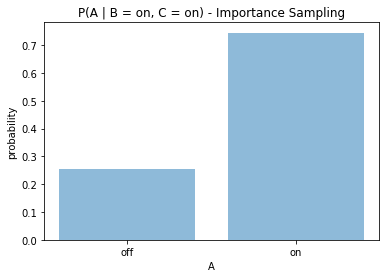

In [22]:
A_posterior = pyro.infer.Importance(conditioned_model, num_samples=10000).run()
A_marginal = EmpiricalMarginal(A_posterior,"A")
A_samples = [A_marginal().item() for _ in range(10000)]
A_unique, A_counts = np.unique(A_samples, return_counts=True)

plt.bar(A_unique, A_counts/len(A_samples), align='center', alpha=0.5)
plt.xticks(A_unique, A_alias)
plt.ylabel('probability')
plt.xlabel('A')
plt.title('P(A | B = on, C = on) - Importance Sampling')

### The probability of $P(A = on\ | \  B = on, C = on)$ is very close to 0.75 which is the value we got from the empirical calculation

### $P(A = on\ | \  \text{do}(B = on), C = on)$

In [25]:
intervention_model = pyro.do(model, data={'B': torch.tensor(1)})

In [26]:
conditioned_intervention_model = pyro.condition(intervention_model, data={'C':torch.tensor(1)})

Text(0.5, 1.0, 'P(A | do(B=on), C = on) - Importance Sampling')

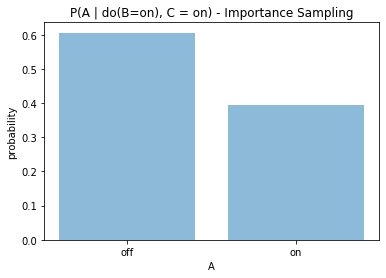

In [27]:
A_posterior_intervened = pyro.infer.Importance(conditioned_intervention_model, num_samples=10000).run()
A_marginal_intervened = EmpiricalMarginal(A_posterior_intervened,"A")
A_samples_intervened = [A_marginal_intervened().item() for _ in range(10000)]
A_unique_intervened, A_counts_intervened = np.unique(A_samples_intervened, return_counts=True)

plt.bar(A_unique_intervened, A_counts_intervened/len(A_samples_intervened), align='center', alpha=0.5)
plt.xticks(A_unique_intervened, A_alias)
plt.ylabel('probability')
plt.xlabel('A')
plt.title('P(A | do(B=on), C = on) - Importance Sampling')

### The probability of $P(A = on\ | \  \text{do}(B = on), C = on)$ is ~0.4 which is what we got from the empirical calculation.